<a href="https://colab.research.google.com/github/sanjaynagi/AgamPrimer/blob/main/Primer-Design-in-Anopheles-gambiae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, install some packages we require
!pip install AgamPrimer==0.3.1 primer3-py malariagen_data -q 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 397 kB 7.6 MB/s 
     |████████████████████████████████| 71 kB 267 kB/s 
     |████████████████████████████████| 3.3 MB 62.6 MB/s 
     |████████████████████████████████| 185 kB 70.4 MB/s 
     |████████████████████████████████| 140 kB 52.9 MB/s 
     |████████████████████████████████| 301 kB 58.2 MB/s 
     |████████████████████████████████| 2.3 MB 38.2 MB/s 
     |████████████████████████████████| 5.7 MB 60.2 MB/s 
     |████████████████████████████████| 1.1 MB 58.3 MB/s 
     |████████████████████████████████| 271 kB 55.6 MB/s 
     |████████████████████████████████| 144 kB 61.2 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 6.6 MB 43.7 MB/s 


In [2]:
# Import libraries 
import AgamPrimer
import pandas as pd
import malariagen_data
import numpy as np
import primer3
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches

#**Primer design considering genetic variation in *Anopheles gambiae***
**Author**: [Sanjay Curtis Nagi](https://sanjaynagi.github.io/)    
**Email**: sanjay.nagi@lstmed.ac.uk

Often, we would like to design primers for PCR applications, such as genotyping (PCR, TaqMan, LNA) or gene expression qPCR (SYBR, TaqMan, LNA). However, single nucleotide polymorphisms (SNPs) in primer binding sites can result in differences or failures in PCR amplification, referred to as null alleles. 

In general, mismatches caused by SNPs are more of a problem as you move towards the 3' end. I recommend reading a really good article on this topic on the IDT website - [Consider SNPs when designing PCR and qPCR assays](https://eu.idtdna.com/pages/education/decoded/article/considering-snps-when-designing-pcr-and-qpcr-assays). In *An. gambiae s.l*, there is a [huge amount of genetic variation](https://genome.cshlp.org/content/30/10/1533.full); a SNP found approximately every 1.9 bases (!), which makes considering SNPs even more important when designing molecular assays. Thanks to primer3-py and the fantastic malariagen_data package, we can do all of this in the cloud, hosted by google!


####**Google Colab**

If you are unfamiliar with iPython notebooks and google colab, I encourage you to watch the following [introduction](https://www.youtube.com/watch?v=inN8seMm7UI). In general, the cells can be run by pressing the play button next to each cell, and should be run in order.

In [41]:
#@title **Selecting Primer Parameters** { run: "auto" }
#@markdown In the below cells, replace the values with those desired for your primers.

assay_type = 'gDNA primers + probe'           #@param ["gDNA primers", "gDNA primers + probe", "probe", "qPCR primers"]
assay_name = 'vgsc'        #@param {type:"string"}
min_amplicon_size = 40        #@param {type:"integer"}
max_amplicon_size = 201      #@param {type:"integer"}
amplicon_size_range = [[min_amplicon_size, max_amplicon_size]]
n_primer_pairs = 8            #@param {type:"slider", min:1, max:20, step:1}

#@markdown    
#@markdown target_loc is required for gDNA primers and probes, and transcript required for qPCR primers.
contig =  "2L"                #@param ['2L', '2R', '3L', '3R', 'X']

target_loc =  2422652                 #@param {type:"integer"}
transcript =  'AGAP004707-RD'         #@param {type:"string"} 


if assay_type == 'gDNA':
  assert target_loc > 0, "Target location must be above 0 and less than the contig length"
elif assay_type == 'qPCR':
  assert len(transcript) > 2, "Transcript ID is not valid, should be vectorbase ID such as 'AGAP004707-RD'"

Load sequence data for chromosomal arm of choice, using the [malariagen_data API](https://malariagen.github.io/vector-data/ag3/api.html):

In [27]:
# Connect to the malariagen_data ag3 API
ag3 = malariagen_data.Ag3() #pre=True
genome_seq = ag3.genome_sequence(region=contig)
print(f"Our genome sequence for {contig} is {genome_seq.shape[0]} bp long")

Our genome sequence for 2L is 49364325 bp long


Now we need to extract the bit of sequence we need. We will use functions in the [AgamPrimer](https://pypi.org/project/AgamPrimer/) package.

In [28]:
if any(item in assay_type for item in ['gDNA', 'probe']):
  # genomic DNA
  target_sequence, gdna_pos, seq_parameters = AgamPrimer.prepare_gDNA_sequence(target_loc=target_loc, amplicon_size_range=amplicon_size_range, genome_seq=genome_seq, assay_name=assay_name, assay_type=assay_type)
elif assay_type == 'qPCR primers':
  # quantitative PCR 
  target_sequence, exon_junctions, gdna_pos, seq_parameters = AgamPrimer.prepare_cDNA_sequence(transcript=transcript, gff=ag3.geneset(), genome_seq=genome_seq, assay_name=assay_name)

The target sequence is 321 bases long
the target snp is 160 bp into our target sequence


Now we have our target sequence. Lets take a look...

In [29]:
target_sequence

'ATGATCTGCCAAGATGGAATTTTACAGATTTCATGCATTCCTTCATGATTGTGTTCCGTGTGCTATGCGGAGAATGGATTGAATCAATGTGGGATTGTATGCTTGTCGGTGATGTATCCTGCATACCATTTTTCTTGGCCACTGTAGTGATAGGAAATTTAGTCGTAAGTAATGCAAATTAACATGGACCAAGATCGTTTTTACATGACATTGTTTTGCAGGTGCTTAACCTTTTCTTAGCCTTGCTTTTGTCAAATTTTGGTTCATCATCCTTGTCTGCACCAACGGCAGATAATGAGACCAACAAGATTGCAGAAGCGT'

We need to set up some python dictionaries containing our sequence and primer parameters, this will be our input to primer3. In the below cell, you can modify or add primer3 parameters, such as optimal TM, GC content etc etc. A full list of possible parameters and their functions can be found in the [primer3 manual](https://htmlpreview.github.io/?https://github.com/libnano/primer3-py/master/primer3/src/libprimer3/primer3_manual.htm).

In [37]:
primer_parameters  =  {
        'PRIMER_NUM_RETURN':n_primer_pairs,
        'PRIMER_OPT_SIZE': 20,
        'PRIMER_TASK':'generic',
        'PRIMER_MIN_SIZE': 17,
        'PRIMER_MAX_SIZE': 24,
        'PRIMER_OPT_TM': 60.0,
        'PRIMER_MIN_TM': 57.0,
        'PRIMER_MAX_TM': 63.0,
        'PRIMER_MIN_GC': 30.0,
        'PRIMER_MAX_GC': 75.0,
        'PRIMER_PRODUCT_SIZE_RANGE': amplicon_size_range,
        'PRIMER_MIN_THREE_PRIME_DISTANCE':3,          # 3 to prevent successive pairs being one base shift
        'PRIMER_INTERNAL_OPT_SIZE': 16,               # Probe size preferences if selected, otherwise ignored
        'PRIMER_INTERNAL_MIN_SIZE': 10,
        'PRIMER_INTERNAL_MAX_SIZE': 22,
        'PRIMER_INTERNAL_MIN_TM': 45,
        'PRIMER_INTERNAL_MAX_TM':70,                # Probe considerations are quite relaxed, assumed that LNAs will be used later to affect TM
        # Extra primer3 parameters can go here
        # In the same format as above                       
    }

primer_parameters = AgamPrimer.primer_params(primer_parameters, assay_type) ## adds some parameters depending on assay type

#### **Run the primer3 algorithm!**

In [38]:
primer_dict = primer3.designPrimers(seq_args=seq_parameters, global_args=primer_parameters)

It should be *fast*. The output, which we call 'primer_dict', is a python dictionary containing the full results from primer3. We will turn this into a pandas dataframe (i.e a useful table), containing just the necessary bits of information. First, we'll print some information from the primer3 run.

In [39]:
AgamPrimer.primer3_run_statistics(primer_dict, assay_type)

PRIMER_LEFT_EXPLAIN  :  considered 1124, GC content failed 86, low tm 663, high tm 38, high hairpin stability 3, ok 334 

PRIMER_RIGHT_EXPLAIN  :  considered 1052, GC content failed 114, low tm 619, high tm 38, high hairpin stability 13, ok 268 

PRIMER_INTERNAL_EXPLAIN  :  considered 510, overlap excluded region 302, GC content failed 3, low tm 196, ok 9 

PRIMER_PAIR_EXPLAIN  :  considered 738, unacceptable product size 729, primer in pair overlaps a primer in a better pair 1122, ok 9 

PRIMER_LEFT_NUM_RETURNED  :  8 

PRIMER_RIGHT_NUM_RETURNED  :  8 

PRIMER_INTERNAL_NUM_RETURNED  :  8 

PRIMER_PAIR_NUM_RETURNED  :  8 



if you have few or no primers returned, the explanations may indicate which parameters are helpful to relax. Now lets turn the results into a pandas dataframe.

In [10]:
primer_df = AgamPrimer.primer3_to_pandas(primer_dict, assay_type)
primer_df

8


primer_pair,0,1,2,3,4,5,6,7
parameter,,,,,,,,
PRIMER_LEFT_SEQUENCE,CACTTGTACGGCTCCACCTT,CCGGTTGCCATATATCGCCA,CCCACGGTCGCAAAGTTAGT,CAACACTGCCGCCAACATTC,TATATCGCCAACACTGCCGC,TTGTACGGCTCCACCTTTGC,AGCTCACACCGCCATTGTTA,GCCATATATCGCCAACACTGC
PRIMER_RIGHT_SEQUENCE,TGGTTTGCGTAGTGTTTGCG,TACAGGACGATGCAAACGCT,ATGTGGGCACGATGGAGTAC,GGCACGATGGAGTACAGGAC,TAAGAACGTGTTCAGCCCGG,GACGATGCAAACGCTGGTAA,TTGCGTAGTGTTTGCGTAGT,TGGAGTACAGGACGATGCAA
PRIMER_INTERNAL_SEQUENCE,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA
PRIMER_LEFT_TM,59.965104,60.32121,60.601841,60.664166,60.878523,60.887387,59.963836,59.802279
PRIMER_RIGHT_TM,59.971758,60.037697,59.821932,60.179108,60.320073,59.206139,58.144487,58.737583
PRIMER_INTERNAL_TM,50.77965,50.77965,50.77965,50.77965,50.77965,50.77965,50.77965,50.77965
PRIMER_LEFT_GC_PERCENT,55.0,55.0,55.0,55.0,55.0,55.0,50.0,52.380952
PRIMER_RIGHT_GC_PERCENT,50.0,50.0,55.0,60.0,55.0,50.0,45.0,50.0
PRIMER_INTERNAL_GC_PERCENT,47.368421,47.368421,47.368421,47.368421,47.368421,47.368421,47.368421,47.368421



We can write this to .tsv and excel files, which can be explored in other editors. To download a file from colab to your local computer, click the folder panel on the left-hand sidebar, the three dots next your primers.tsv/.xlsx file, and download.

In [11]:
primer_df.to_csv(f"{assay_name}.{assay_type}.primers.tsv", sep="\t")
primer_df.to_excel(f"{assay_name}.{assay_type}.primers.xlsx")

##**Looking for variation using the ag1000g resource and malariagen API**

In Ag3, samples are organised into sample sets. We can load any sample set from the Ag3 resource, but there are quite a few! Lets look at what each sample set contains, breaking it down by species, year and country. 

In [12]:
metadata = ag3.sample_metadata()

Load sample metadata:   0%|          | 0/28 [00:00<?, ?it/s]

In [13]:
pivot_country_year_taxon = (
    metadata
    .pivot_table(
        index=["sample_set", "year", "country"], 
        columns=["taxon"], 
        values="sample_id",
        aggfunc="count",
        fill_value=0
    )
)

pivot_country_year_taxon

taxon                                                arabiensis  coluzzii  \
sample_set   year  country                                                  
AG1000G-AO    2009 Angola                                     0        81   
AG1000G-BF-A  2012 Burkina Faso                               0        82   
AG1000G-BF-B  2014 Burkina Faso                               3        53   
AG1000G-BF-C  2004 Burkina Faso                               0         0   
AG1000G-CD    2015 Democratic Republic of the Congo           0         0   
AG1000G-CF    1993 Central African Republic                   0         5   
              1994 Central African Republic                   0        13   
AG1000G-CI    2012 Cote d'Ivoire                              0        80   
AG1000G-CM-A  2009 Cameroon                                   0         0   
AG1000G-CM-B  2005 Cameroon                                   0         7   
AG1000G-CM-C  2013 Cameroon                                   2        19   
AG1000G-FR    2011 Mayotte                                    0         0   
AG1000G-GA-A  2000 Gabon                                      0         0   
AG1000G-GH    2012 Ghana                                      0        64   
AG1000G-GM-A  2011 Gambia, The                                0         0   
AG1000G-GM-B  2012 Gambia, The                                0         2   
AG1000G-GM-C  2012 Gambia, The                                0        12   
AG1000G-GN-A  2012 Guinea                                     0         4   
AG1000G-GN-B  2012 Guinea                                     0         7   
                   Mali                                       0        28   
AG1000G-GQ    2002 Equatorial Guinea                          0         0   
AG1000G-GW    2010 Guinea-Bissau                              0         0   
AG1000G-KE    2000 Kenya                                      0         0   
              2007 Kenya                                      3         0   
              2012 Kenya                                     10         0   
AG1000G-ML-A  2014 Mali                                       0        27   
AG1000G-ML-B  2004 Mali                                       2        36   
AG1000G-MW    2015 Malawi                                    41         0   
AG1000G-MZ    2003 Mozambique                                 0         0   
              2004 Mozambique                                 0         0   
AG1000G-TZ    2012 Tanzania                                  87         0   
              2013 Tanzania                                   1         0   
              2015 Tanzania                                 137         0   
AG1000G-UG    2012 Uganda                                    82         0   
AG1000G-X    -1    Lab Cross                                  0        74   

taxon                                                gambiae  gcx1  gcx2  \
sample_set   year  country                                                 
AG1000G-AO    2009 Angola                                  0     0     0   
AG1000G-BF-A  2012 Burkina Faso                           98     0     0   
AG1000G-BF-B  2014 Burkina Faso                           46     0     0   
AG1000G-BF-C  2004 Burkina Faso                           13     0     0   
AG1000G-CD    2015 Democratic Republic of the Congo       76     0     0   
AG1000G-CF    1993 Central African Republic                2     0     0   
              1994 Central African Republic               53     0     0   
AG1000G-CI    2012 Cote d'Ivoire                           0     0     0   
AG1000G-CM-A  2009 Cameroon                              303     0     0   
AG1000G-CM-B  2005 Cameroon                               90     0     0   
AG1000G-CM-C  2013 Cameroon                               23     0     0   
AG1000G-FR    2011 Mayotte                                23     0     0   
AG1000G-GA-A  2000 Gabon                                  69     0     0   
AG1000G-GH

Here, we can see the breakdown by sample set for country, species and year. For the purposes of this notebook, let's use the Ghana sample set. If we wanted to use all sample sets, we could supply '3.0' instead of a sample set, which will load all samples from the ag3.0 release.

In [14]:
sample_set = 'AG1000G-GH'          # sample_set = '3.0' .you can also supply lists with multiple sample sets e.g ['AG1000G-GH', 'AG1000G-CI', 'AG1000G-BF-A]

### **Plot allele frequencies in primers locations**

Now we can plot the primers and the frequency of any alternate alleles. When calculating allele frequencies, we will take the sum of all alternate alleles, as we are interested here in any mutations which are different from the reference genome. 

We will also plot the primer Tm, GC and genomic spans of each primer binding site. We can use this to identify primers which may be suitable, particularly trying to avoid SNPs in the 3' end. 

5
5
5
5
5
5
5
5


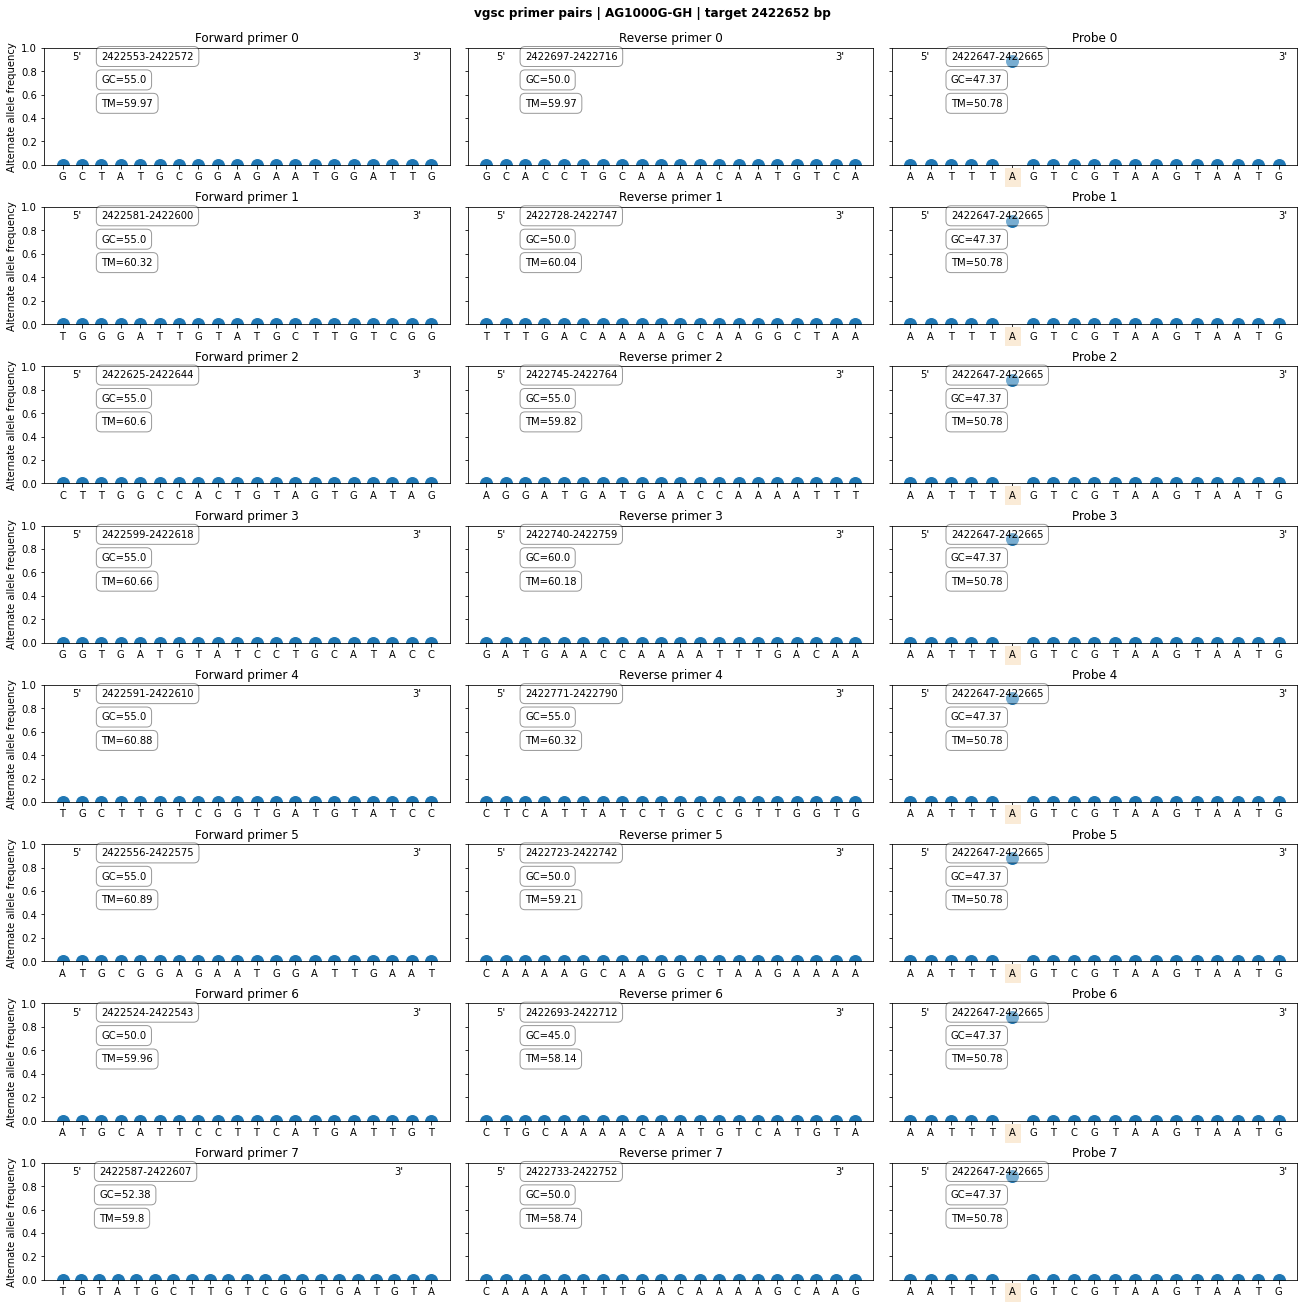

In [42]:
results_dict = AgamPrimer.plot_primer_ag3_frequencies(primer_df=primer_df,
                                                gdna_pos=gdna_pos,
                                                contig=contig,
                                                sample_set=sample_set, 
                                                assay_type=assay_type,
                                                seq_parameters=seq_parameters,
                                                save=True)

Now lets plot these primer pairs across the genome, highlighting where they are in relation to any exons nearby...

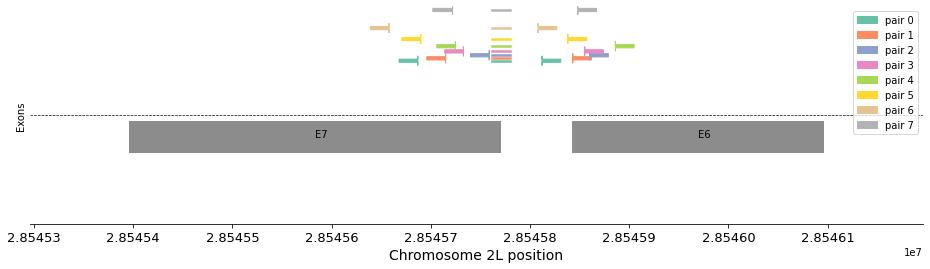

In [16]:
fig, ax = plt.subplots(1,1, figsize=[16,4])
AgamPrimer.plot_primer_locs(primer_res_dict=results_dict, assay_type=assay_type, gff=ag3.geneset(), contig=contig, seq_parameters=seq_parameters, n_primer_pairs=n_primer_pairs, ax=ax)

In [17]:
primer_df

primer_pair,0,1,2,3,4,5,6,7
parameter,,,,,,,,
PRIMER_LEFT_SEQUENCE,CACTTGTACGGCTCCACCTT,CCGGTTGCCATATATCGCCA,CCCACGGTCGCAAAGTTAGT,CAACACTGCCGCCAACATTC,TATATCGCCAACACTGCCGC,TTGTACGGCTCCACCTTTGC,AGCTCACACCGCCATTGTTA,GCCATATATCGCCAACACTGC
PRIMER_RIGHT_SEQUENCE,TGGTTTGCGTAGTGTTTGCG,TACAGGACGATGCAAACGCT,ATGTGGGCACGATGGAGTAC,GGCACGATGGAGTACAGGAC,TAAGAACGTGTTCAGCCCGG,GACGATGCAAACGCTGGTAA,TTGCGTAGTGTTTGCGTAGT,TGGAGTACAGGACGATGCAA
PRIMER_INTERNAL_SEQUENCE,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA,ACAACTCGACCTATTGCGA
PRIMER_LEFT_TM,59.965104,60.32121,60.601841,60.664166,60.878523,60.887387,59.963836,59.802279
PRIMER_RIGHT_TM,59.971758,60.037697,59.821932,60.179108,60.320073,59.206139,58.144487,58.737583
PRIMER_INTERNAL_TM,50.77965,50.77965,50.77965,50.77965,50.77965,50.77965,50.77965,50.77965
PRIMER_LEFT_GC_PERCENT,55.0,55.0,55.0,55.0,55.0,55.0,50.0,52.380952
PRIMER_RIGHT_GC_PERCENT,50.0,50.0,55.0,60.0,55.0,50.0,45.0,50.0
PRIMER_INTERNAL_GC_PERCENT,47.368421,47.368421,47.368421,47.368421,47.368421,47.368421,47.368421,47.368421


####**We may now have designed suitable primers. However, there are some further considerations...**


- Primers **must** be run in [**NCBI Blast**](https://blast.ncbi.nlm.nih.gov/Blast.cgi), to ensure specificity against the host organism, and specificity for the genomic location of interest. I would recommend both doing a general blast and also specifically against *An. gambiae* (TaxonID = 7165).

- If in multiplexed use with other primers or probes, primers must not interact with each other. This can be investigated on a one by one basis using the IDT tool [oligoanalyzer](https://eu.idtdna.com/calc/analyzer).

- If designing Locked Nucleic Acid (LNA) probes for SNP detection, you will want to play around with the placement of LNAs in the oligo sequence, which can allow short probes (~10-14 bases) to bind with high affinity and discriminate between SNPs. IDT have a tool for this which allow you to check the binding affinity between mismatches, though it requires a log in https://eu.idtdna.com/calc/analyzer/lna. 

- Many more considerations.... [IDT - How to design primers and probes for PCR and qPCR](https://eu.idtdna.com/pages/education/decoded/article/designing-pcr-primers-and-probes)   


  
---


####**Future development**

Any contributions or suggestions on how we can improve this notebook, are more than welcome. Please [email](mailto:sanjay.nagi@lstmed.ac.uk) or log an [issue on github](https://github.com/sanjaynagi/primerDesignAg/issues). This notebook and source code for AgamPrimer are located here - https://github.com/sanjaynagi/AgamPrimer/